In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH='../../../data/aclImdb/'
TRN_PATH='train/all/'
VAL_PATH='test/all/'
TRN=f'{PATH}{TRN_PATH}'
VAL=f'{PATH}{VAL_PATH}'

In [3]:
trn_files = os.listdir(TRN)

In [4]:
trn_files[0]

'39562_0.txt'

In [5]:
review = !cat {TRN}{trn_files[0]}
review[0]

"At first, I thought this was a sequel to Entre Nous. Many of the same people who made one film made another, they are supposedly written by and about the same people and the character names are repeated. However, those playing the roles are NOT the same (although Jean-Pierre Bacri stars in BOTH films but plays totally different roles). Because of this, some viewers might be VERY disappointed. It reminded me of the movie A Christmas Story. There was a little-known sequel named Ollie Hopnoodle's Haven of Bliss that had NONE of the original characters or charm--and because of this it was soon forgotten. Now the only difference I see is that both these French films are about equally good. Apart from the many differences mentioned above, this film doesn't seem to have a negative view of men (in Entre Nous, the male leads were all Neanderthals), but portrays the mother in the story as a self-absorbed woman whose kids seemed to be an afterthought--her new boy-toy was about 90% of her focus. 

In [6]:
# number of words in train set
!find {TRN} -name '*txt' | xargs cat | wc -w

17486270


In [7]:
# number of words in val set
!find {VAL} -name '*txt' | xargs cat | wc -w

5686609


In [8]:
spacy_tok = spacy.load('en')

In [9]:
spacy_tok = spacy.load('en')

In [10]:
' '.join([sent.string.strip() for sent in spacy_tok(review[0])])

"At first , I thought this was a sequel to Entre Nous . Many of the same people who made one film made another , they are supposedly written by and about the same people and the character names are repeated . However , those playing the roles are NOT the same ( although Jean - Pierre Bacri stars in BOTH films but plays totally different roles ) . Because of this , some viewers might be VERY disappointed . It reminded me of the movie A Christmas Story . There was a little - known sequel named Ollie Hopnoodle 's Haven of Bliss that had NONE of the original characters or charm -- and because of this it was soon forgotten . Now the only difference I see is that both these French films are about equally good . Apart from the many differences mentioned above , this film does n't seem to have a negative view of men ( in Entre Nous , the male leads were all Neanderthals ) , but portrays the mother in the story as a self - absorbed woman whose kids seemed to be an afterthought -- her new boy - 

In [11]:
TEXT = data.Field(lower=True, tokenize="spacy")

In [12]:
bs=64; bptt=70

In [13]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [14]:
pickle.dump(TEXT.vocab, open(f'{PATH}models/TEXT.pkl','wb'))

In [15]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [16]:
TEXT.vocab.stoi['the']

2

In [17]:
[md.trn_ds[0].text[:12]]

[['at',
  'first',
  ',',
  'i',
  'thought',
  'this',
  'was',
  'a',
  'sequel',
  'to',
  'entre',
  'nous']]

In [18]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
    40
   102
     3
    12
   213
    13
    19
     6
   701
     8
 36172
     0
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [19]:
next(iter(md.trn_dl))

(Variable containing:
     40     20     11  ...      20     11   2519
    102      6     16  ...    9324     27      4
      3   8852     31  ...      20      2      8
         ...            ⋱           ...         
     10    103      8  ...      14   6236     30
    215    116     36  ...      32     10     43
    122   2893      6  ...      41     11      9
 [torch.cuda.LongTensor of size 62x64 (GPU 0)], Variable containing:
    102
      6
     16
   ⋮   
      0
     24
   1379
 [torch.cuda.LongTensor of size 3968 (GPU 0)])

## TRAIN

In [20]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [21]:
# batches; # unique tokens in the vocab; # tokens in the training set; # sentences
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(4583, 37392, 1, 20540756)

In [22]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [23]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [ ]:
learner.lr_find()

 78%|███████▊  | 3562/4583 [16:01<04:35,  3.71it/s, loss=20.4]

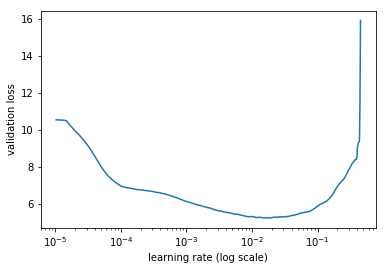

In [ ]:
learner.sched.plot()

In [ ]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

 12%|█▏        | 537/4583 [02:25<18:24,  3.66it/s, loss=5.94] 

In [ ]:
learner.save_encoder('adam1_enc')

In [ ]:
learner.load_encoder('adam1_enc')

In [ ]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

In [ ]:
learner.save_encoder('adam3_enc_10')

In [ ]:
learner.load_encoder('adam3_enc_10')

learner.fit(3e-3, 1, wds=1e-6, cycle_len=20)

learner.save_encoder('adam3_enc_20')

learner.load_encoder('adam3_enc_20')

### ... up to the point the model is not underfitting or overfitting

In [ ]:
#metric PERPLEXITY - exp of loss
math.exp(4.165)

### test - TBD

### SENTIMENT CLASSIFICATION (using pretrained model, finetune it and use it for classification)

In [ ]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [ ]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

In [ ]:
IMDB_LABEL

In [ ]:
t = splits[0].examples[0]

In [ ]:
t.label, ' '.join(t.text[:16])

In [ ]:
md2 = TextData.from_splits(PATH,splits,bs)

In [ ]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_10_enc')

In [ ]:
m3.clip=25.
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [ ]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
m3.fit(lrs, 5, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy_np(*m3.predict_with_targs())